<a href="https://colab.research.google.com/github/ucfilho/RTC_case_01_optimization/blob/master/RTC_DE_case_01_if_H_mar_25_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Functions used in this code
# buildMatriz(x): return three slots (Ind_I,Ind_J,deltaT)
#                 the function also returns the Tout, Tion
#                 Tout and Tin temperatures of particle in each stage
#                 Ind_I,Ind_J represents streams (hot i and cold j)
#                 deltaT represents hot temperature changing
# Temperatura_Carga(mCp,Ind_I,Ind_J,deltaT,Tin,Tout):
#                 return temperatures of particles after gain or loss of energy
#                 return heat load of particles after gain or loss of energy
#                 return error to apply penalty (error=1 is penalty)
# Area(U,Tin,Tout,Ind_I,Ind_J,deltaT):
#                 return Area of heat exchanger used in heat and cold  streams
# Utilidades(tempAlvo,Tout,mCp):
#                 return Area of heat exchanger using utilities
#                 return the kW of utilities used
# CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
#                 return the cost composed by use of utilities and depreciation 
#                 of heat exchangers
# FUN(x): return the cost
#                integrate the use of all functions described above
# Variables used in this code:
# x: population of particles
# NPAR: number of particles
# Trocas: number of exchanges allowed between the streams
# mCp=[4,2,1.5,3] #[kW/K]
# tempInicial initial temperature in each strem (kelvin)
# tempAlvo target of temperatures to be reached by each stream
# cost function to be optimized
# mCp heat capacity of stream (composed by flux multiplied by Cp)

In [3]:
!git clone https://github.com/ucfilho/raianars_RTC_optimization #clonar do Github
%cd raianars_RTC_optimization
import de_bounds_matriz

fatal: destination path 'raianars_RTC_optimization' already exists and is not an empty directory.
/content/raianars_RTC_optimization


In [0]:
def buildMatriz(x):
  global Trocas, tempInicial, tempAtual 
  NPAR=1
  cols=len(tempInicial)
  size=3*cols
  x=np.array(x).reshape(1,size)
  # print('x=');print(x)
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  Tin=np.zeros((NPAR,Trocas))
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    for j in range(Trocas):
      #print('[i,j]=%d %d'%(i,j))
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 
    for jj in range(cols):
      Tin[i,jj]=tempInicial[jj]
      Tout[i,jj]=tempAtual[jj]
  return Ind_I,Ind_J,deltaT, Tin, Tout

In [0]:
def Temperatura(x):
  global Trocas, mCp,tempInicial
  
  NPAR=1
  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  rows,cols=Tout.shape
  Tatual=np.zeros(cols)
  for j in range(cols):
    Tatual[j]=tempInicial[j]
    for i in range(rows):
      Tout[i,j]=tempInicial[j]

  #Tatual=np.copy(np.array(tempInicial))
  '''
  print('======================')
  print(Tout)
  print(tempInicial)
  print('== == == == == == == ==')
  '''
  erro=np.zeros((NPAR)) # valor erro se torna erro=1 quando ha algum erro e vai penalizar
  for ki in range(NPAR):
    for kj in range(Trocas):
      #Tin=np.copy(Tout)
      k=kj
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]
      
      tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
      tempSaidaF=-mCp[kj]*deltaT[ki,kj]/(mCp[j])+Tout[ki,j]
      flag=0 # flag : indica que nao entra no teste logico
      # usei flag no lugar q ifs pq a identacao ficou melhor assim
      if(Tout[ki,i] > Tout[ki,j]): #Tquente maior Tfria: vaores atuais
        if(tempSaidaQ > tempSaidaF): #Tquente maior Tfria: saidas
          flag=1
      if(flag>0):
        Tout[ki,i]=tempSaidaQ
        Tout[ki,j]=tempSaidaF
      else:
        erro[ki]=1

  return Tout,erro

In [0]:
def Area(x):

  global mCp,tempAlvo,tempInicial,Trocas,U
  
  NPAR=1
  
  Area=[]

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)

  Area_Particula=[]

  for k in range(Trocas):

    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]

    Told_i=Tatual[i]
    Told_j=Tatual[j]

    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)
    deltaT1=Tatual[i]-tempSaidaF
    deltaT2=tempSaidaQ-Tatual[j]
    try:
      A=(deltaT1-deltaT2)
      B=np.log((deltaT1/deltaT2))
      deltaTMediaLog=A/B
    except:
      deltaTMediaLog=1e99
  
    if(deltaTMediaLog==1e99):
      AreaCalc=1e99
    else:
      AreaCalc=abs(deltaT[0,k]*mCp[i]/(U*deltaTMediaLog))

    if(Told_i==Tatual[i]):
      AreaCalc=0

    if(Told_j==Tatual[j]):
      AreaCalc=0

      Area_Particula.append(AreaCalc)
      
  Area.append(Area_Particula)

  return Area

In [0]:
def Utilidades(tempAlvo,Tout,mCp):

  cols=len(mCp)
  NPAR=1

  
  '''
  caso I cita TUQin=553 e TQout=552, TUFin=303 TUFout=353
  '''
  
  TUQin=553
  TUQout=552
  TUFin=303 
  TUFout=353
  
  Areas=[]
  cargaUQtodas=[]
  cargaUFtodas=[]

  for ki in range(NPAR):
    areaTrocador=[]
    cargaUQ=0
    cargaUF=0
    for j in range(cols):
      delta=tempAlvo[j]-Tout[ki,j]
      if(delta>0):#usa UQ
        cargaUQ=cargaUQ+mCp[j]*delta
        deltaT1=(TUQin-tempAlvo[j])
        deltaT2=(TUQout-Tout[ki,j])

        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99

        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(delta)/(U*deltaTMediaLog))))

      elif(delta==0):#nao usa UF e UQ
        deltaTMediaLog=0
        areaTrocador.append(0) 

      else:#usa UF
        deltaT1=(Tout[ki,j]-TUFout)
        deltaT2=(tempAlvo[j]-TUFin)     
        cargaUF=cargaUF+mCp[j]*(-delta)

        #UF -> água resfriada -> entra a 303K e sai a 353K
        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99
        
        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(-delta)/(U*deltaTMediaLog))))

    cargaUQtodas.append(cargaUQ)
    cargaUFtodas.append(cargaUF)

    Areas.append(areaTrocador)

  return Areas, cargaUQtodas,cargaUFtodas 


In [0]:
def CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
  global coefCustoUQ,coefCustoUF
  
  NPAR=1

  cost=np.zeros((NPAR))

  for i in range(NPAR):
    cargaUQ=cargaUQtodas[i]
    cargaUF=cargaUFtodas[i]
    areaTrocadores=Area[i]
    areaUtilidades=Utilidades[i]
    costTrocadores=0

    for it in areaTrocadores:
      if(it<1e99):
        costTrocadores=costTrocadores+300*it**0.5
      else:
        costTrocadores=1e99
        break
    
      for wii in areaUtilidades:
        if(costTrocadores<1e99):
          if(wii<1e99):
            costTrocadores=costTrocadores+300*wii**0.5
          else:
            costTrocadores=1e99
            break
        else:
          break
          
    costUQ=coefCustoUQ*cargaUQ
    costUF=coefCustoUF*cargaUF
    
    if(costTrocadores==1e99):
      cost[i]=1e99
    else:
      cost[i]=costUQ+costUF+costTrocadores
      
  return cost

In [0]:
def Numb(x):
  global mCp,tempAlvo,tempInicial,Trocas

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)
  Ttrocas=np.zeros((rows+4,cols))# feito em quaduplicata so para melhorar o visual
  for i in range(2):
    for j in range(cols):
      Ttrocas[i,j]=np.copy(Tatual[j])
  cont=1
  #Ttrocas.append(Tatual)
  #Ttrocas.append(Tatual) # feito em duplicata so para melhorar o visual
  for k in range(Trocas):
    cont=cont+1
    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]
    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)

    for jj in range(cols):
      Ttrocas[cont,jj]=Tatual[jj]  


  for jj in range(cols): # feito em duplicata so para melhorar o visual
    Ttrocas[cont+1,jj]=tempAlvo[jj]
    Ttrocas[cont+2,jj]=tempAlvo[jj]

  
  return Ttrocas


In [0]:
#FUN calcula o TAC para um determinado arranjo
#  cada calculo é feito em uma funcao a parte Fun usa todas funcoes 

def FUN(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  
  NPAR=1
  
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tout, Erro=Temperatura(x)
  areaTrocadores =Area(x)
  areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)
  
  # print(funr)

  return funr 

In [0]:
#********************PROGRAMA PRINCIPAL*************************

Trocas=4
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453.0,393.0,523.0,533.0] #[K]
tempAtual=np.copy(tempInicial) 
#tempAtual=[453,393,523,533] #[K]
tempAlvo=[513.0,508.0,403.0,433.0] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]





MAX=np.array([3,3,3,3,1,1,1,1,0,0,0,0])
MIN=np.array([2,2,2,2,0,0,0,0,-100,-100,-100,-100])
#MAX=np.array([3,3,3,3,3,3,3,3,0,0,0,0])
#MIN=np.array([0,0,0,0,0,0,0,0,-100,-100,-100,-100])
#MAX=np.array([3,2,3,2,1,1,1,1,0,0,0,0])
#MIN=np.array([3,2,3,2,1,1,1,1,-100,-100,-100,-100])
#MAX=np.array([3,3,3,3,1,1,1,1,0,0,0,0])
#MIN=np.array([2,2,2,2,0,0,0,0,-100,-100,-100,-100])
#MIN=np.array([2,2,2,2,0,0,0,0,-40,-40,-40,-40])





bounds=[]
for k in range(len(MAX)):
  bounds.append((MIN[k],MAX[k]))


# print(bounds)



In [12]:
fobj=FUN
mut=0.5
crossp=0.5
NPAR=50
its=100
cols=12
x=np.zeros((NPAR,cols))
for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]

x,BEST,FOBEST,XY,BEST_XY=de_bounds_matriz.de(bounds, mut, crossp, 
                                             NPAR, its,fobj,x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [13]:
print('FOBEST=');print(FOBEST)

FOBEST=
[17993.71223404]


In [14]:
print(BEST)
Tout, Erro=Temperatura(BEST)
print('=============================')
print(Tout)

[  2.           2.           3.           2.6680965    0.43616147
   0.5157165    0.07872599   0.56539122 -34.54521083 -44.61736524
 -29.84190503 -19.31743439]
[[498.73592522 466.59351684 443.83742393 483.84066057]]


In [0]:
# 488.335883  455.439176  443.837424  483.840661
#  479.346348  474.410568  452.543807  478.825920
# 483.359863  502.005094  486.673748  438.013247
# 490.5  498.857143  476.142857  435.857143

In [16]:
Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(BEST)
print(Ind_I)
print(Ind_J)
print(deltaT)


[[2 2 3 3]]
[[0 1 0 1]]
[[-34.54521083 -44.61736524 -29.84190503 -19.31743439]]


In [17]:
Busca=Numb(BEST)
print(pd.DataFrame(Busca))
df=pd.DataFrame(Busca)

            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  465.954454  393.000000  488.454789  533.000000
3  465.954454  426.463024  443.837424  533.000000
4  488.335883  426.463024  443.837424  503.158095
5  488.335883  455.439176  443.837424  483.840661
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


In [18]:
print(df)


            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  465.954454  393.000000  488.454789  533.000000
3  465.954454  426.463024  443.837424  533.000000
4  488.335883  426.463024  443.837424  503.158095
5  488.335883  455.439176  443.837424  483.840661
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


Text(0, 0.5, 'Temperature (K)')

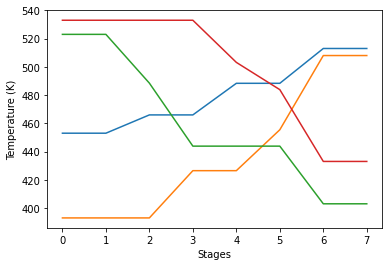

In [19]:

Streams=4
Change=range(Streams+4) # Streams+4 so para ficar com um visual melhor
for k in range(Streams):
  plt.plot(Change,df.iloc[:,k])
plt.xlabel('Stages')
plt.ylabel('Temperature (K)')


In [20]:
print(tempInicial)
print(tempAlvo)
print(df)

[453.0, 393.0, 523.0, 533.0]
[513.0, 508.0, 403.0, 433.0]
            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  465.954454  393.000000  488.454789  533.000000
3  465.954454  426.463024  443.837424  533.000000
4  488.335883  426.463024  443.837424  503.158095
5  488.335883  455.439176  443.837424  483.840661
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


In [21]:
x=BEST
Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
Tout, Erro=Temperatura(x)
areaTrocadores =Area(x)
areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
print(Tout)
print(cost)

[[498.73592522 466.59351684 443.83742393 483.84066057]]
[17993.71223404]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
